In [1]:
%env SUMO_HOME="/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo"
%env LIBSUMO_AS_TRACI=1
%env PATH=$PATH:/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo/bin


env: SUMO_HOME="/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo"
env: LIBSUMO_AS_TRACI=1
env: PATH=$PATH:/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo/bin


In [2]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn as nn
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import os
import sys
import matplotlib.pyplot as plt

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

from env import SumoEnvironment
from sumo_rl.agents import QLAgent
from sumo_rl.exploration import EpsilonGreedy

from custom_observation import CustomEmergencyObservationFunction
from custom_reward import emergency_reward_fn

/Users/atharva/Documents/CSE/RL/rl-final/ve/lib/python3.9/site-packages/traci/__init__.py:41: UserWarning: Could not import libsumo, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo, falling back to pure python traci (%s)." % e)


In [3]:
class SharedActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_actions, is_discrete=True):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fcX = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_actions)
        self.softmax = nn.Softmax(dim=-1)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fcX(x))
        act_pro = self.softmax(self.fc2(x))
        value = self.fc3(x)
        return act_pro, value

In [4]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=True,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )
model = SharedActorCritic(12, 128, env.action_space.n, True)
target_model = deepcopy(model)
m = torch.load("auto_sumo.pt")
model.load_state_dict(m)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 2ms, vehicles TOT 0 ACT 0 BUF 0)                      


<All keys matched successfully>

In [5]:
import traci

if traci.isLoaded():
    traci.close()

In [6]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=False,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

n_episodes = 10
reward_per_episode = [0]*n_episodes
wait_per_episode_lane_1 = [0] * n_episodes
wait_per_episode_lane_2 = [0] * n_episodes

for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}
    obs_tensor = torch.from_numpy(obs['t'])
    # play one episode
    while not done["__all__"]:
        with torch.no_grad():
            actor, critic = model(obs_tensor)
            action = torch.argmax(actor).item()
        next_obs, reward, done, info = env.step({'t': action})
        obs_tensor = torch.from_numpy(next_obs['t'])
        if len(info["emergency_waiting_time"]) > 0:
            for k,v in info["emergency_waiting_time"].items():
                if k == "flow_emergency_ns_1":
                    wait_per_episode_lane_1[episode] += v
                elif k == "flow_emergency_ns_2":
                    wait_per_episode_lane_2[episode] += v
                    
        

 Retrying in 1 seconds


Step #0.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 2495 ACT 46 BUF 969)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 2553 ACT 52 BUF 955)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 2605 ACT 56 BUF 972)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 2579 ACT 52 BUF 943)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 2511 ACT 49 BUF 999)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 2510 ACT 54 BUF 928)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 2608 ACT 52 BUF 987)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 2591 ACT 56 BUF 987)             
 Retrying in 1 seconds


Step #5000.00 (1ms ~= 1000.00*RT, ~51000.00UPS, TraCI: 23ms, vehicles TOT 2578 ACT 51 BUF 
 Retrying in 1 seconds


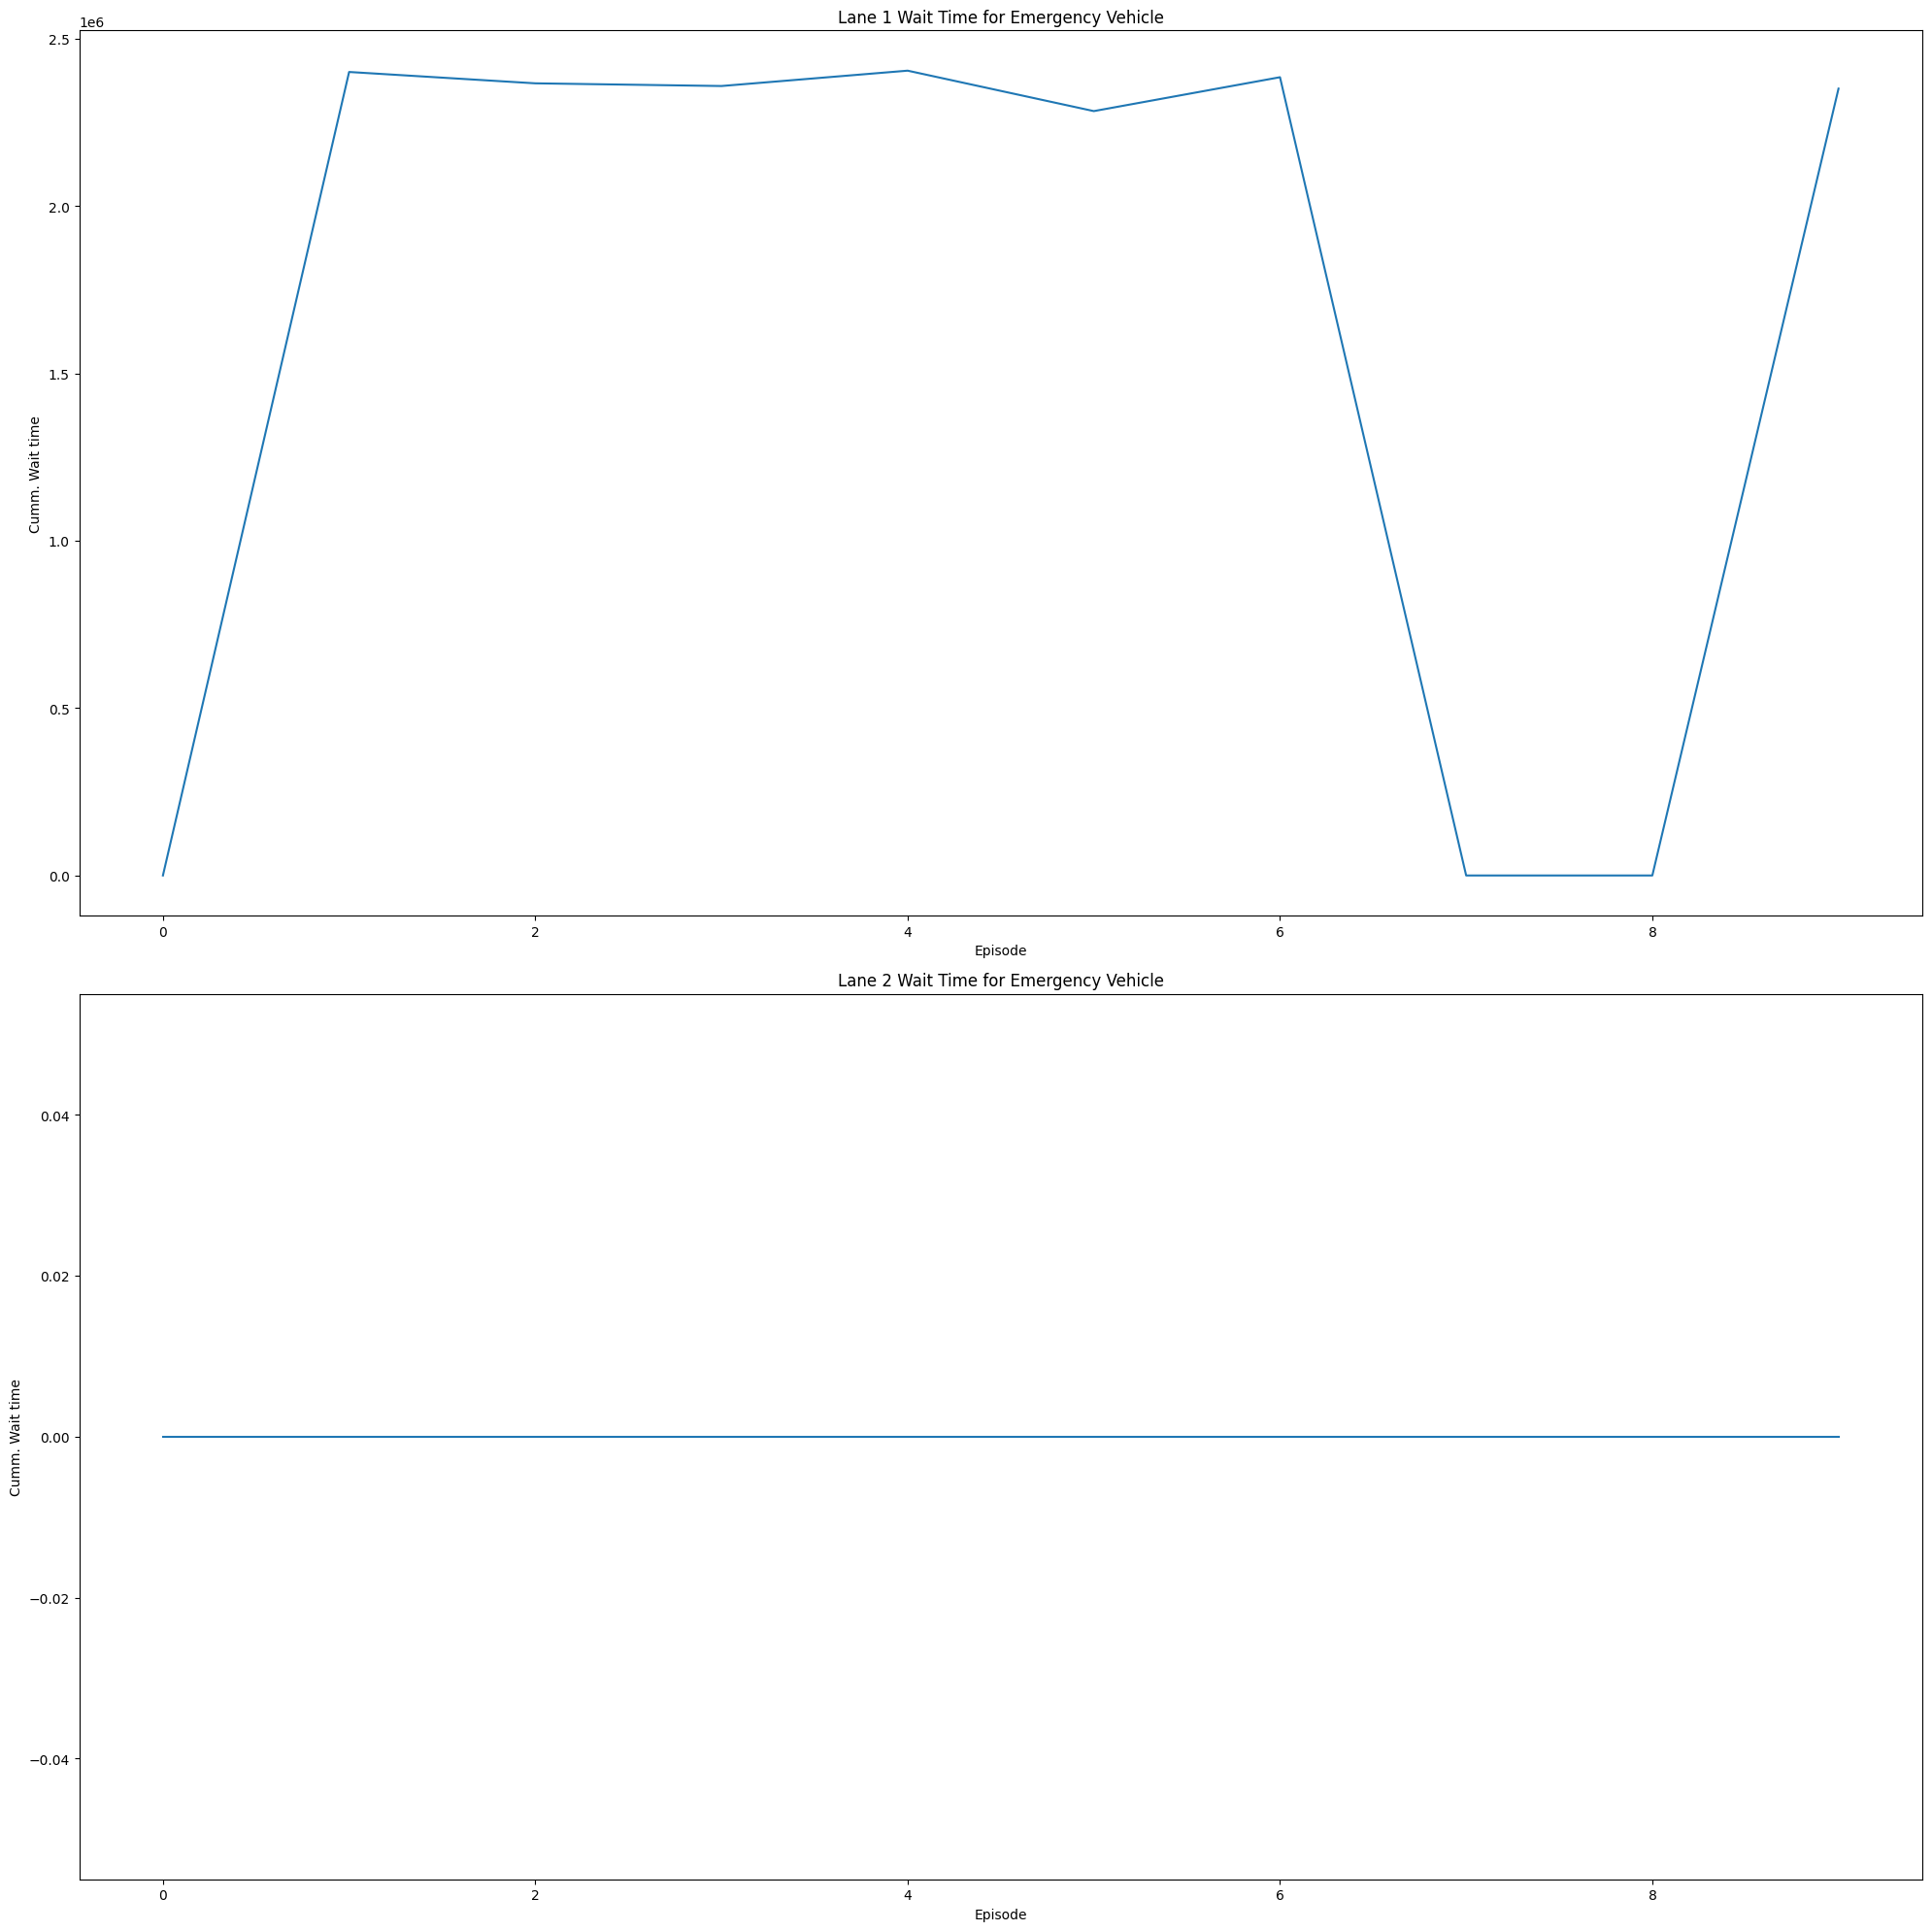

In [8]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(2, 1, figsize=(20, 20))

axs[0].plot(range(len(wait_per_episode_lane_1)), wait_per_episode_lane_1)
axs[0].set_title("Lane 1 Wait Time for Emergency Vehicle")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Cumm. Wait time")

axs[1].plot(range(len(wait_per_episode_lane_2)), wait_per_episode_lane_2)
axs[1].set_title("Lane 2 Wait Time for Emergency Vehicle")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Cumm. Wait time")

plt.tight_layout()
plt.show()